In [1]:
import numpy as np

import matplotlib.pyplot as plt
import cv2
import sys

from PIL import Image
from utils import plot_filtered_image, plot_multiple_rows

%matplotlib inline

## Edge Detection

### Image gradients

OpenCV provides three types of gradient filters or High-pass filters, Sobel, Scharr and Laplacian.

First, we will use the `cv2.Sobel` to implement the Sobel operator. Sobel operators is a joint Gaussian smoothing plus differentiation operation, so it is more resistant to noise. You can specify the direction of derivatives to be taken, vertical or horizontal (by the arguments, yorder and xorder respectively). You can also specify the size of kernel by the argument ksize. If `ksize = -1`, a $3\times3$ Scharr filter is used which gives better results than $3\times3$ Sobel filter. Please see the [docs](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d) for kernels used.

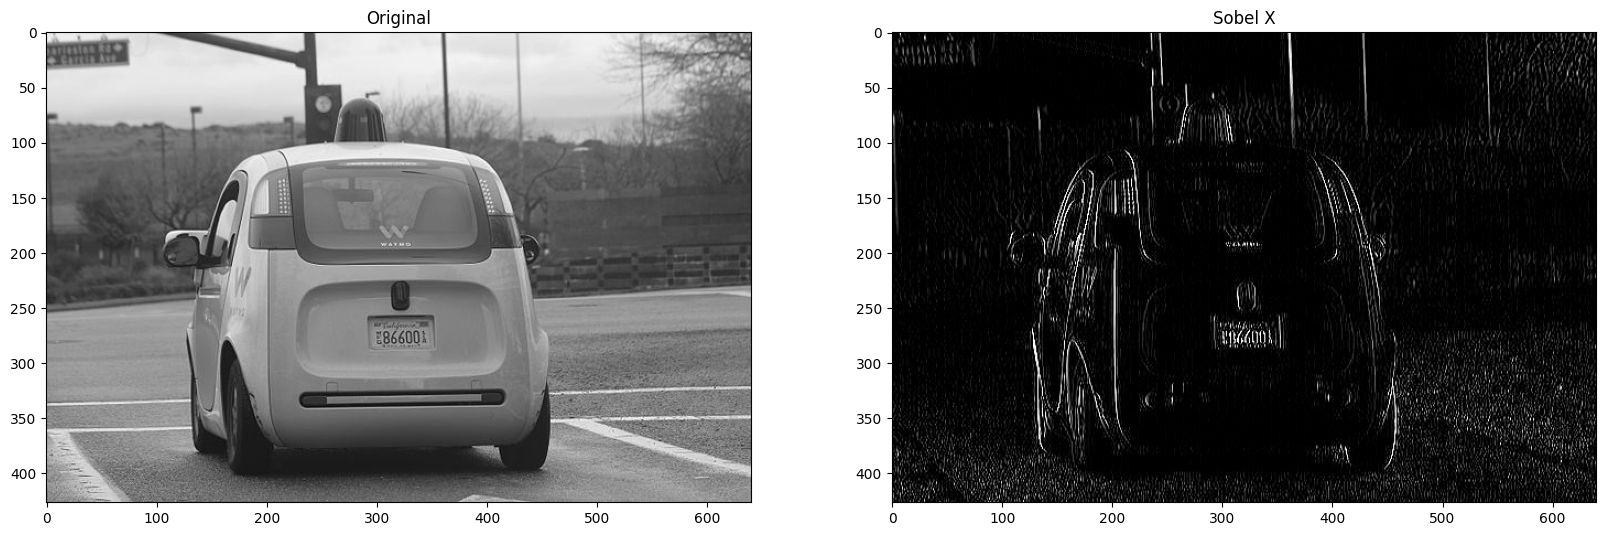

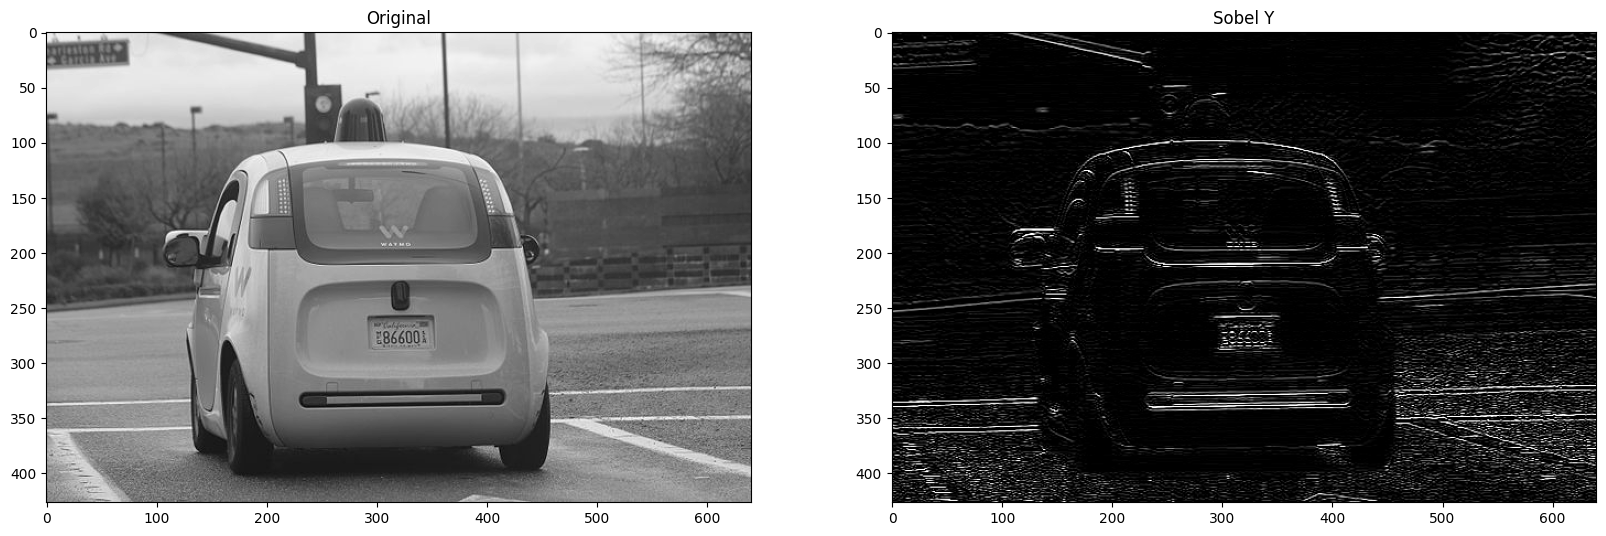

In [2]:
img = Image.open('images/waymo_car.jpg').convert("L")
img = np.array(img)

### TODO
### START YOUR CODE HERE ###
# Apply the sobel filter across horizontal and vertical directions
sobel_x = cv2.Sobel(img, ddepth=-1, dx=2, dy=0, ksize=3)
sobel_y = cv2.Sobel(img, ddepth=-1, dx=0, dy=2, ksize=3)
### END YOUR CODE HERE ###

plot_filtered_image(img, sobel_x, "Sobel X", figsize=(20,20))
plot_filtered_image(img, sobel_y, "Sobel Y", figsize=(20,20))
#plot_filtered_image(img, np.clip(sobel_x+sobel_y,0,255), "Sobel XY", figsize=(20,20))

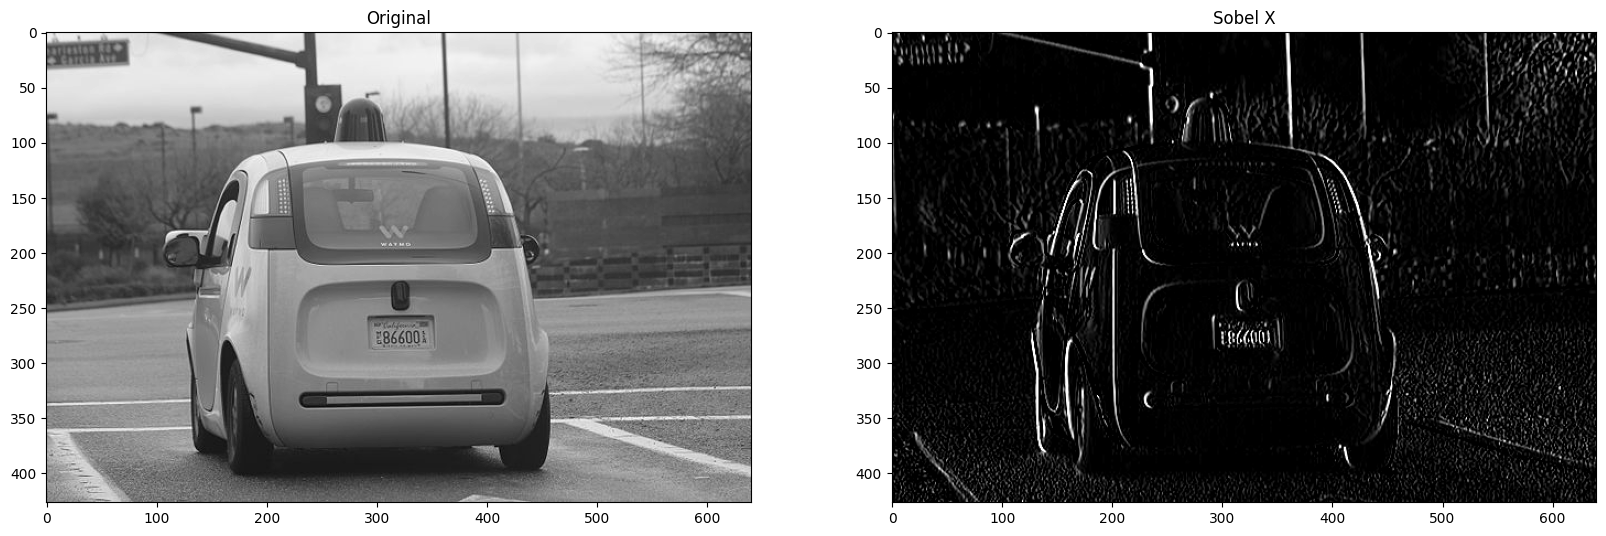

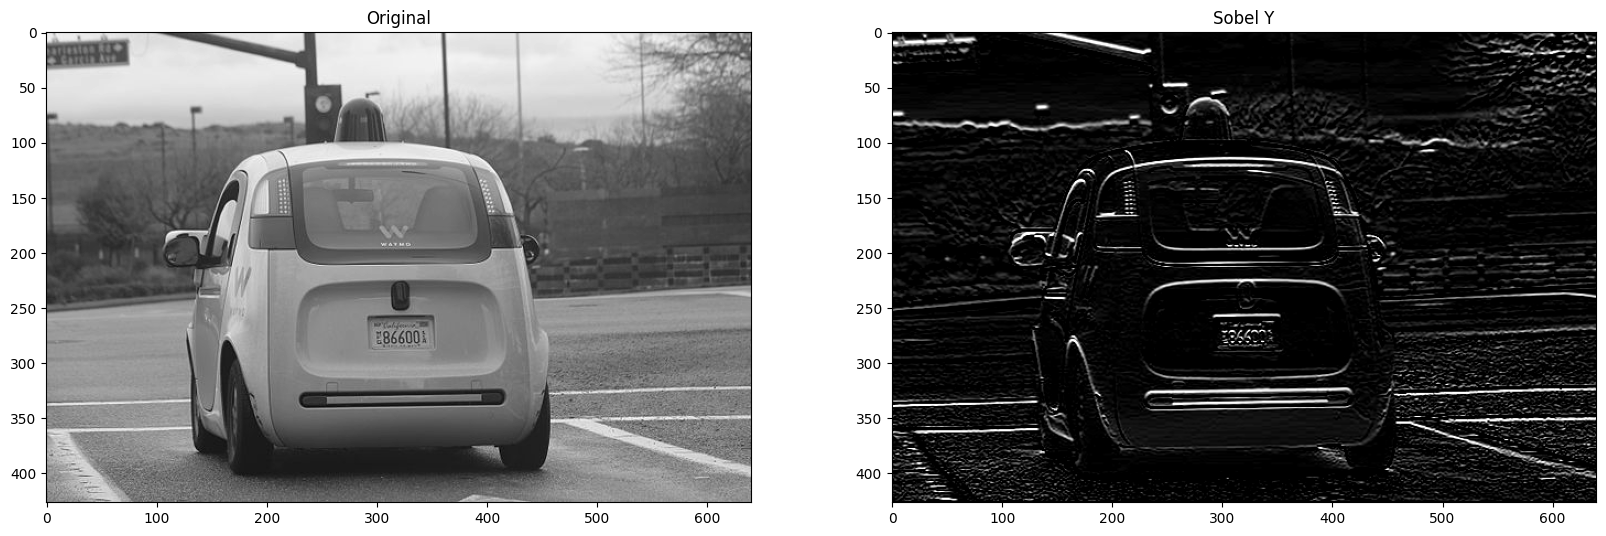

In [3]:
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y_kernel = np.array([
    [-1,-2,-1],
    [0, 0, 0],
    [1, 2, 1]
])

sobel_x = cv2.filter2D(src=img, ddepth=-1, kernel=cv2.flip(sobel_x_kernel,-1))

sobel_y = cv2.filter2D(src=img, ddepth=-1, kernel=cv2.flip(sobel_y_kernel,-1))

plot_filtered_image(img, sobel_x, "Sobel X", figsize=(20,20))
plot_filtered_image(img, sobel_y, "Sobel Y", figsize=(20,20))


In [9]:
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y_kernel = np.array([
    [-1,-2,-1],
    [0, 0, 0],
    [1, 2, 1]
])

img_test = np.array([
    [  0,   0,   0,   0,   0],
    [  0, 255, 255, 255,   0],
    [  0, 255,   0, 255,   0],
    [  0, 255, 255, 255,   0],
    [  0,   0,   0,   0,   0]
])

def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

sobel_x_test = convolve2D(img_test, sobel_x_kernel)
sobel_y_test = convolve2D(img_test, sobel_y_kernel)

print(f'Original:\n{img_test}\n\nSobel X:\n{sobel_x_test}\n\nSobel Y:\n{sobel_y_test}')

Original:
[[  0   0   0   0   0]
 [  0 255 255 255   0]
 [  0 255   0 255   0]
 [  0 255 255 255   0]
 [  0   0   0   0   0]]

Sobel X:
[[-510.    0.  510.]
 [-510.    0.  510.]
 [-510.    0.  510.]]

Sobel Y:
[[-510. -510. -510.]
 [   0.    0.    0.]
 [ 510.  510.  510.]]


Do you see any difference between the vertical and horizontal filters?

Next, we will implement the `cv2.Laplacian` ([docs](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6)) operator. It calculates the Laplacian of the image given by the relation, $\Delta I = \frac{\delta^2I}{\delta x^2} + \frac{\delta^2I}{\delta y^2}$ where each derivative is found using Sobel derivatives. If ksize = 1, then following kernel is used for filtering:

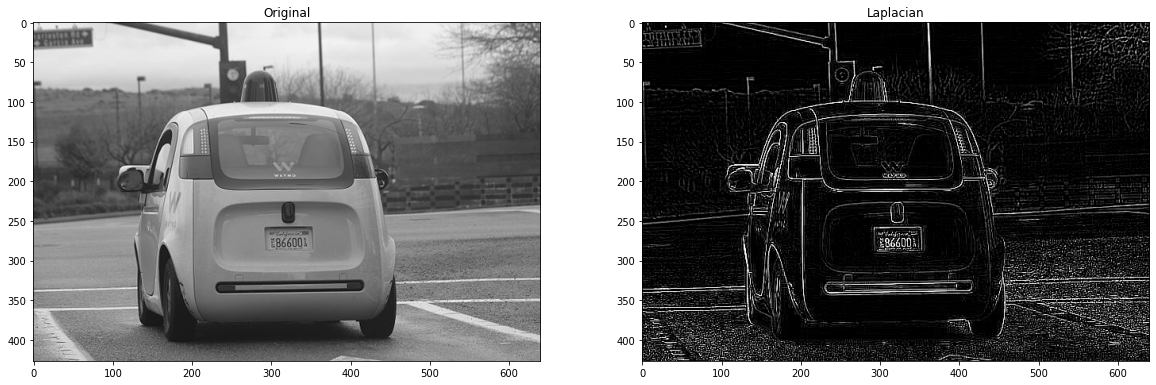

In [ ]:
### TODO
### START YOUR CODE HERE ###
# Define a laplacian filter with kernel size equal 3x3
laplacian = cv2.Laplacian(img, ddepth=-1, ksize=3)
### END YOUR CODE HERE ###

plot_filtered_image(img, laplacian, "Laplacian", figsize=(20,20))

The edge detection methods we have seen so far have some problem in common. They are very **sensitive to noise**!

The optimal edge detector must be accurate, minimizing the number of false positives and false negatives; have precise localization, pinpointing edges at the positions where they actually occur; and have single response, ensuring that only one edge is found where there only is one edge. In the next section, we'll see a better solution!

### Canny Edge Detection

The Canny edge detector is the most commonly used edge detector in the field. It detects edges by:

1. **Noise Reduction**: since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a Gaussian filter.
2. **Finding Intensity Gradient of the Image**: smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction ($G_x$) and vertical direction ($G_y$).
3. **Non-maximum Suppression**: after getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient.
4. **Hysteresis Thresholding**: any edges with intensity gradient more than *maxVal* are sure to be edges and those below *minVal* are sure to be non-edges, so discarded.

OpenCV implements the Canny Edge Detector, thus we can implement it using just one line of code! Check the `cv2.Canny` ([docs](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)) function to check how it works.


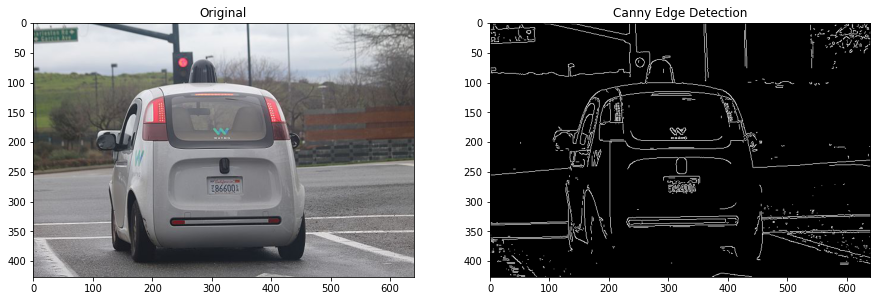

In [ ]:
img = np.array(Image.open("images/waymo_car.jpg"))

### TODO
### START YOUR CODE HERE ###
# Detect the edges using the Canny edge detector
edges = cv2.Canny(img,190,230)
### START YOUR CODE HERE ###

plot_filtered_image(img, edges, "Canny Edge Detection", figsize=(15,15))